#### 머신러닝 프로젝트
- 데이터셋 : used_car_data.csv
- 목표 : 다양한 모델로 데이터셋 분석 및 모델 생성.



In [421]:
# %pip install koreanize_matplotlib

In [422]:
## [1-1] 모듈로딩 
from _utils import tools as ts, RegressionModule as rm
from _utils.RegressionModule import RegressionModule as rm

import seaborn as sns
import pandas as pd # 데이터 분석 및 전처리
import numpy as np # 숫자처리
import matplotlib.pyplot as plt # 데이터 시각화
from sklearn.linear_model import LinearRegression ## ML 알고리즘
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
                            ## 성능평가 모듈
from sklearn.model_selection import train_test_split, KFold
                            ## 데이터셋 분리 관련 모듈
                            ## 학습/검증/테스트 
                                                    ## 교차검증\
from sklearn.preprocessing import PolynomialFeatures # 폴리. 컬럼추가
from sklearn.linear_model import Ridge, Lasso, ElasticNet            

from sklearn.utils.discovery import *
from sklearn.metrics import *   
from scipy import stats

import koreanize_matplotlib
                            

In [423]:
originDF = pd.DataFrame(pd.read_csv('../data/used_cars_data.csv',index_col='S.No.'))

In [424]:
carDF = originDF.copy()

컬럼설명<hr>
S.No.: 차량의 일련 번호 <br>
Name: 차량의 이름 (브랜드 이름과 모델 이름 포함)<br>
Location: 차량이 판매되거나 구매 가능한 위치 (도시)<br>
Year: 차량의 제조 연도<br>
Kilometers_driven: 이전 소유자가 차량을 운전한 총 거리 (KM 단위)<br>
Fuel_Type: 차량이 사용하는 연료 종류 (가솔린, 디젤, 전기, CNG, LPG)<br>
Transmission: 차량에 사용된 변속기 종류 (자동/수동)<br>
Owner: 차량의 소유 유형<br>
Mileage: 자동차 회사가 제공하는 표준 연비 (kmpl 또는 km/kg 단위)<br>
Engine: 차량 엔진의 배기량 (CC 단위)<br>
Power: 차량 엔진의 최대 출력 (bhp 단위)<br>
Seats: 차량의 좌석 수<br>
New_Price: 동일 모델의 새 차량 가격 (인도 루피 Lakhs 단위, 1 Lakh = 100,000 INR)<br>
Price: 중고차 가격 (인도 루피 Lakhs 단위, 1 Lakh = 100,000 INR<br>

In [425]:
aList = carDF[carDF['New_Price'].isna()]['Name'].unique().tolist()
with open('keyword', "w") as f:
      for item in aList:
        f.write(str(item) + "\n")  # Convert item to string and add newline

In [426]:
# 환율 (예시: 1 INR = 15 KRW)
exchange_rate = 16.75

# 중고차 가격을 한국 원화로 변환 후 백만 원 단위로 변환
carDF['Price'] = (carDF['Price'] * 100000 * exchange_rate) / 1000000

# # 결과 출력
print(carDF[['Price']])

          Price
S.No.          
0       2.93125
1      20.93750
2       7.53750
3      10.05000
4      29.71450
...         ...
7248        NaN
7249        NaN
7250        NaN
7251        NaN
7252        NaN

[7253 rows x 1 columns]


In [427]:
carDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7253 entries, 0 to 7252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Year               7253 non-null   int64  
 3   Kilometers_Driven  7253 non-null   int64  
 4   Fuel_Type          7253 non-null   object 
 5   Transmission       7253 non-null   object 
 6   Owner_Type         7253 non-null   object 
 7   Mileage            7251 non-null   object 
 8   Engine             7207 non-null   object 
 9   Power              7207 non-null   object 
 10  Seats              7200 non-null   float64
 11  New_Price          1006 non-null   object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 793.3+ KB


In [428]:
## 각 컬럼별 고유값 갯수 확인
## 범주형, 연속형 데이터 확인
for i in carDF.columns:
    print(i, len(carDF[i].unique()))

Name 2041
Location 11
Year 23
Kilometers_Driven 3660
Fuel_Type 5
Transmission 2
Owner_Type 4
Mileage 451
Engine 151
Power 387
Seats 10
New_Price 626
Price 1374


In [429]:
carDF.isna().sum()
## 널값 상태 확인
## mileeage, Engine, Seats
## engine nan == power 도 없음 46 개이므로 폐기
## New_Price            6247가 null 폐기
## price 1234개는 추후 확인

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
New_Price            6247
Price                1234
dtype: int64

In [430]:
carDF = carDF.drop(index = carDF[carDF['Engine'].isna()].index)
carDF.loc[carDF['Seats'].isna(),'Seats'] = [5,5,5,7,5,5,5]
carDF.loc[carDF['Mileage'].isna(), 'Mileage'] = [0,0]

In [431]:
## name 컬럼 앞의 회사명은 범주형으로 사용가능.

In [432]:
carDF.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
S.No.,,,,,,,,,,,,,
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,2.93125
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,20.93750
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,7.53750
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,10.05000
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,29.71450


In [433]:
## 수치지만 object인 컬럼 수정
# carDF['Mileage'] = carDF['Mileage'].apply(lambda x: x.split())
carDF['Mileage'] = carDF['Mileage'].apply(lambda x: str(x).split()[0] if isinstance(x, str) else x)
carDF["Engine"] = carDF["Engine"].apply(lambda x: str(x).split()[0])
carDF["Power"] = carDF["Power"].apply(lambda x: str(x).split()[0])


In [434]:
carDF.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 0
Engine                  0
Power                   0
Seats                   0
New_Price            6201
Price                1224
dtype: int64

In [435]:
carDF= carDF.drop(index=carDF[carDF['Power']=='null'].index)

In [436]:
#converting object data type to category data type
carDF["Fuel_Type"] = carDF["Fuel_Type"].astype("category")
carDF["Transmission"] = carDF["Transmission"].astype("category")
carDF["Owner_Type"] = carDF["Owner_Type"].astype("category")
#converting datatype  
carDF["Mileage"] = carDF["Mileage"].astype(float)
carDF["Power"] = carDF["Power"].astype(float)
carDF["Engine"]=carDF["Engine"].astype(float)

In [437]:
carDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7078 entries, 0 to 7252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Name               7078 non-null   object  
 1   Location           7078 non-null   object  
 2   Year               7078 non-null   int64   
 3   Kilometers_Driven  7078 non-null   int64   
 4   Fuel_Type          7078 non-null   category
 5   Transmission       7078 non-null   category
 6   Owner_Type         7078 non-null   category
 7   Mileage            7078 non-null   float64 
 8   Engine             7078 non-null   float64 
 9   Power              7078 non-null   float64 
 10  Seats              7078 non-null   float64 
 11  New_Price          1006 non-null   object  
 12  Price              5876 non-null   float64 
dtypes: category(3), float64(5), int64(2), object(3)
memory usage: 629.5+ KB


In [438]:
## 차량 이름 앞의 브랜드명 추출하여 브랜드로, 모델명 추출하여 모델로
carDF['Brand'] = carDF['Name'].str.split(' ').str[0] #Separating Brand name from the Name
carDF['Model'] = carDF['Name'].str.split(' ').str[1] + carDF['Name'].str.split(' ').str[2]

carDF.Brand.unique()
## 'Isuzu', 'ISUZU' 같은걸로 보임.

array(['Maruti', 'Hyundai', 'Honda', 'Audi', 'Nissan', 'Toyota',
       'Volkswagen', 'Tata', 'Land', 'Mitsubishi', 'Renault',
       'Mercedes-Benz', 'BMW', 'Mahindra', 'Ford', 'Porsche', 'Datsun',
       'Jaguar', 'Volvo', 'Chevrolet', 'Skoda', 'Mini', 'Fiat', 'Jeep',
       'Ambassador', 'Isuzu', 'ISUZU', 'Force', 'Bentley', 'Lamborghini',
       'OpelCorsa'], dtype=object)

In [439]:
carDF['Brand'] = carDF['Brand'].str.replace('ISUZU','Isuzu' )
carDF.loc[carDF['Model'].isna(),'Model'] = 'Corsa'

In [440]:
carDF["Brand"] = carDF["Brand"].astype("category")
carDF["Model"] = carDF["Model"].astype("category")

In [441]:
## 제조년도와 현재년도를 이용해 연식 계산

carDF['Current_year']=2025
carDF['Ageofcar']=carDF['Current_year']-carDF['Year']
carDF.drop('Current_year',axis=1,inplace=True)

In [442]:
carDF.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,Ageofcar
count,7078.000000,7.078000e+03,7078.000000,7078.000000,7078.000000,7078.000000,5876.000000,7078.000000
mean,2013.480503,5.825348e+04,18.268227,1620.717717,112.765214,5.284544,16.084464,11.519497
std,3.153077,8.521223e+04,4.369135,596.002717,53.493553,0.809451,18.837939,3.153077
min,1998.000000,1.710000e+02,0.000000,72.000000,34.200000,2.000000,0.737000,6.000000
25%,2012.000000,3.345875e+04,15.260000,1198.000000,75.000000,5.000000,5.891813,9.000000
50%,2014.000000,5.300000e+04,18.250000,1495.000000,94.000000,5.000000,9.631250,11.000000
75%,2016.000000,7.256600e+04,21.100000,1984.000000,138.100000,5.000000,16.770938,13.000000
max,2019.000000,6.500000e+06,33.540000,5998.000000,616.000000,10.000000,268.000000,27.000000


In [443]:
carDF.loc[carDF['Model']=='Prius2009-2016',:]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Brand,Model,Ageofcar
S.No.,,,,,,,,,,,,,,,,
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,0.0,1798.0,73.0,5.0,NaN,21.35625,Toyota,Prius2009-2016,14


In [444]:
carDF.loc[carDF['Model']=='Prius2009-2016', 'Mileage'] = 23.91

In [445]:
carDF['Mileage'].groupby(carDF['Model']).median().sort_values().head(30)

C:\Users\matdo\AppData\Local\Temp\ipykernel_6972\4283817905.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  carDF['Mileage'].groupby(carDF['Model']).median().sort_values().head(30)


Model
Superb3.6              0.00
Jazz2020               0.00
C-ClassProgressive     0.00
EVerito                0.00
GallardoCoupe          6.40
Panamera2010           7.75
SL-ClassSL             8.10
BoxsterS               8.60
ContinentalFlying      8.60
M-ClassML              8.70
AccordV6               9.00
S60D4                  9.00
Superb2.8              9.30
XJ2.0L                 9.43
Pajero4X4              9.50
6Series                9.52
CLS-Class2006-2010     9.90
TT2.0                  9.90
E-Class250            10.00
E-Class230            10.00
370ZAT                10.00
E-ClassE400           10.00
CR-V2.4               10.10
GrandVitara           10.10
FlyingSpur            10.20
Z42009-2013           10.37
A62.8                 10.40
XJ5.0                 10.50
Scorpio2.6            10.50
E-Class200            10.50
Name: Mileage, dtype: float64

In [446]:
carDF.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Brand,Model,Ageofcar
S.No.,,,,,,,,,,,,,,,,
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,2.93125,Maruti,WagonR,15
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,20.93750,Hyundai,Creta1.6,10
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh,7.53750,Honda,JazzV,14
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,10.05000,Maruti,ErtigaVDI,13
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,29.71450,Audi,A4New,12


price의 널값 1200개 처리하기.
- 5876/7078 = 0.8301780163888104
- 약 17%. test size를 0.17로 처리했다고 생각하고. 
- 예측모델을 만든 후 price 가 null인 것을 예측 모델에 넣어 데이터 만들기

- target - Price
- feature - 이름을 제외한 모든 컬럼.

In [447]:
pnullDF = carDF.loc[carDF[carDF['Price'].isna()].index, :]
newDF = carDF.loc[carDF[~carDF['Price'].isna()].index, :]

In [448]:
carDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7078 entries, 0 to 7252
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Name               7078 non-null   object  
 1   Location           7078 non-null   object  
 2   Year               7078 non-null   int64   
 3   Kilometers_Driven  7078 non-null   int64   
 4   Fuel_Type          7078 non-null   category
 5   Transmission       7078 non-null   category
 6   Owner_Type         7078 non-null   category
 7   Mileage            7078 non-null   float64 
 8   Engine             7078 non-null   float64 
 9   Power              7078 non-null   float64 
 10  Seats              7078 non-null   float64 
 11  New_Price          1006 non-null   object  
 12  Price              5876 non-null   float64 
 13  Brand              7078 non-null   category
 14  Model              7078 non-null   category
 15  Ageofcar           7078 non-null   int64   
dtypes: category

In [449]:
carDF.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Brand,Model,Ageofcar
S.No.,,,,,,,,,,,,,,,,
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,2.93125,Maruti,WagonR,15
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,20.93750,Hyundai,Creta1.6,10
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh,7.53750,Honda,JazzV,14
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,10.05000,Maruti,ErtigaVDI,13
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,29.71450,Audi,A4New,12


In [450]:
Brand_dict = {num:i for i, num in enumerate(newDF['Brand'].unique())}
location_dict = {num:i for i, num in enumerate(newDF['Location'].unique())}
trans_dict = {num:i for i, num in enumerate(newDF['Transmission'].unique())}
fuel_dict = {num:i for i, num in enumerate(newDF['Fuel_Type'].unique())}
Model_dict = {num:i for i, num in enumerate(newDF['Model'].unique())}

In [451]:
# newDF['Location'] = newDF['Location'].replace(location_dict)
# newDF['Fuel_Type'] = newDF['Fuel_Type'].replace(fuel_dict)
# newDF['Transmission'] = newDF['Transmission'].replace(trans_dict)
# newDF['Brand'] = newDF['Brand'].replace(Brand_dict)
# newDF['Model'] = newDF['Model'].replace(Model_dict)

# 'Location' 컬럼에 대해 원핫 인코딩 수행

# 원본 DataFrame에 원핫 인코딩된 결과를 시리즈 형태로 추가
# 원핫 인코딩된 시리즈를 다시 원본 값으로 복원
# 1인 위치의 값을 찾아 해당하는 원본 값을 반환


In [452]:
## getdummy  컬럼별 적용

# for i in typeList:
#     source_encoded = pd.get_dummies(newDF[i], prefix=i)
#     newDF[i+'_Encoded'] = list(source_encoded.apply(lambda x: x.tolist(), axis=1))
#     newDF[i+'_Reversed'] = newDF[i+'_Encoded'].apply(lambda x: source_encoded.columns[x.index(1)] if 1 in x else None)



In [453]:
newDF.iloc[:,16:].head()

""
S.No.
0
1
2
3
4


In [454]:
from sklearn.ensemble import RandomForestRegressor

In [455]:
newDF['Car_size'] = np.where(newDF['Engine'] < 900, 1,   # 경차
                      np.where(newDF['Engine'] < 1500, 2,  # 소형차
                      np.where(newDF['Engine'] < 2000, 3,  # 중형차
                                               4)))

In [456]:
## 범주형 데이터들 라벨링하여 넘버링하기
## 로케이션, 브랜드, 모델은 순서 없음.
## 오너타입은 오디널.
##연식은 인코딩필요없음
from sklearn.preprocessing import  OrdinalEncoder


In [457]:
orEn = OrdinalEncoder()
newDF['Owner_Type'] = orEn.fit_transform(newDF[['Owner_Type']])


In [458]:
orEn.inverse_transform(newDF[['Owner_Type']])

array([['First'],
       ['First'],
       ['First'],
       ...,
       ['Second'],
       ['First'],
       ['First']], dtype=object)

In [459]:
newDF['Car_size'] = np.where(newDF['Engine'] < 1200, 1,   # 경차
                      np.where(newDF['Engine'] < 1500, 2,  # 소형차
                      np.where(newDF['Engine'] < 2000, 3,  # 중형차
                   4)))

In [460]:
newDF.columns


Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'New_Price', 'Price', 'Brand', 'Model', 'Ageofcar', 'Car_size'],
      dtype='object')

In [461]:
gDF = newDF.loc[:, ['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price', 'Ageofcar','Car_size'] ]

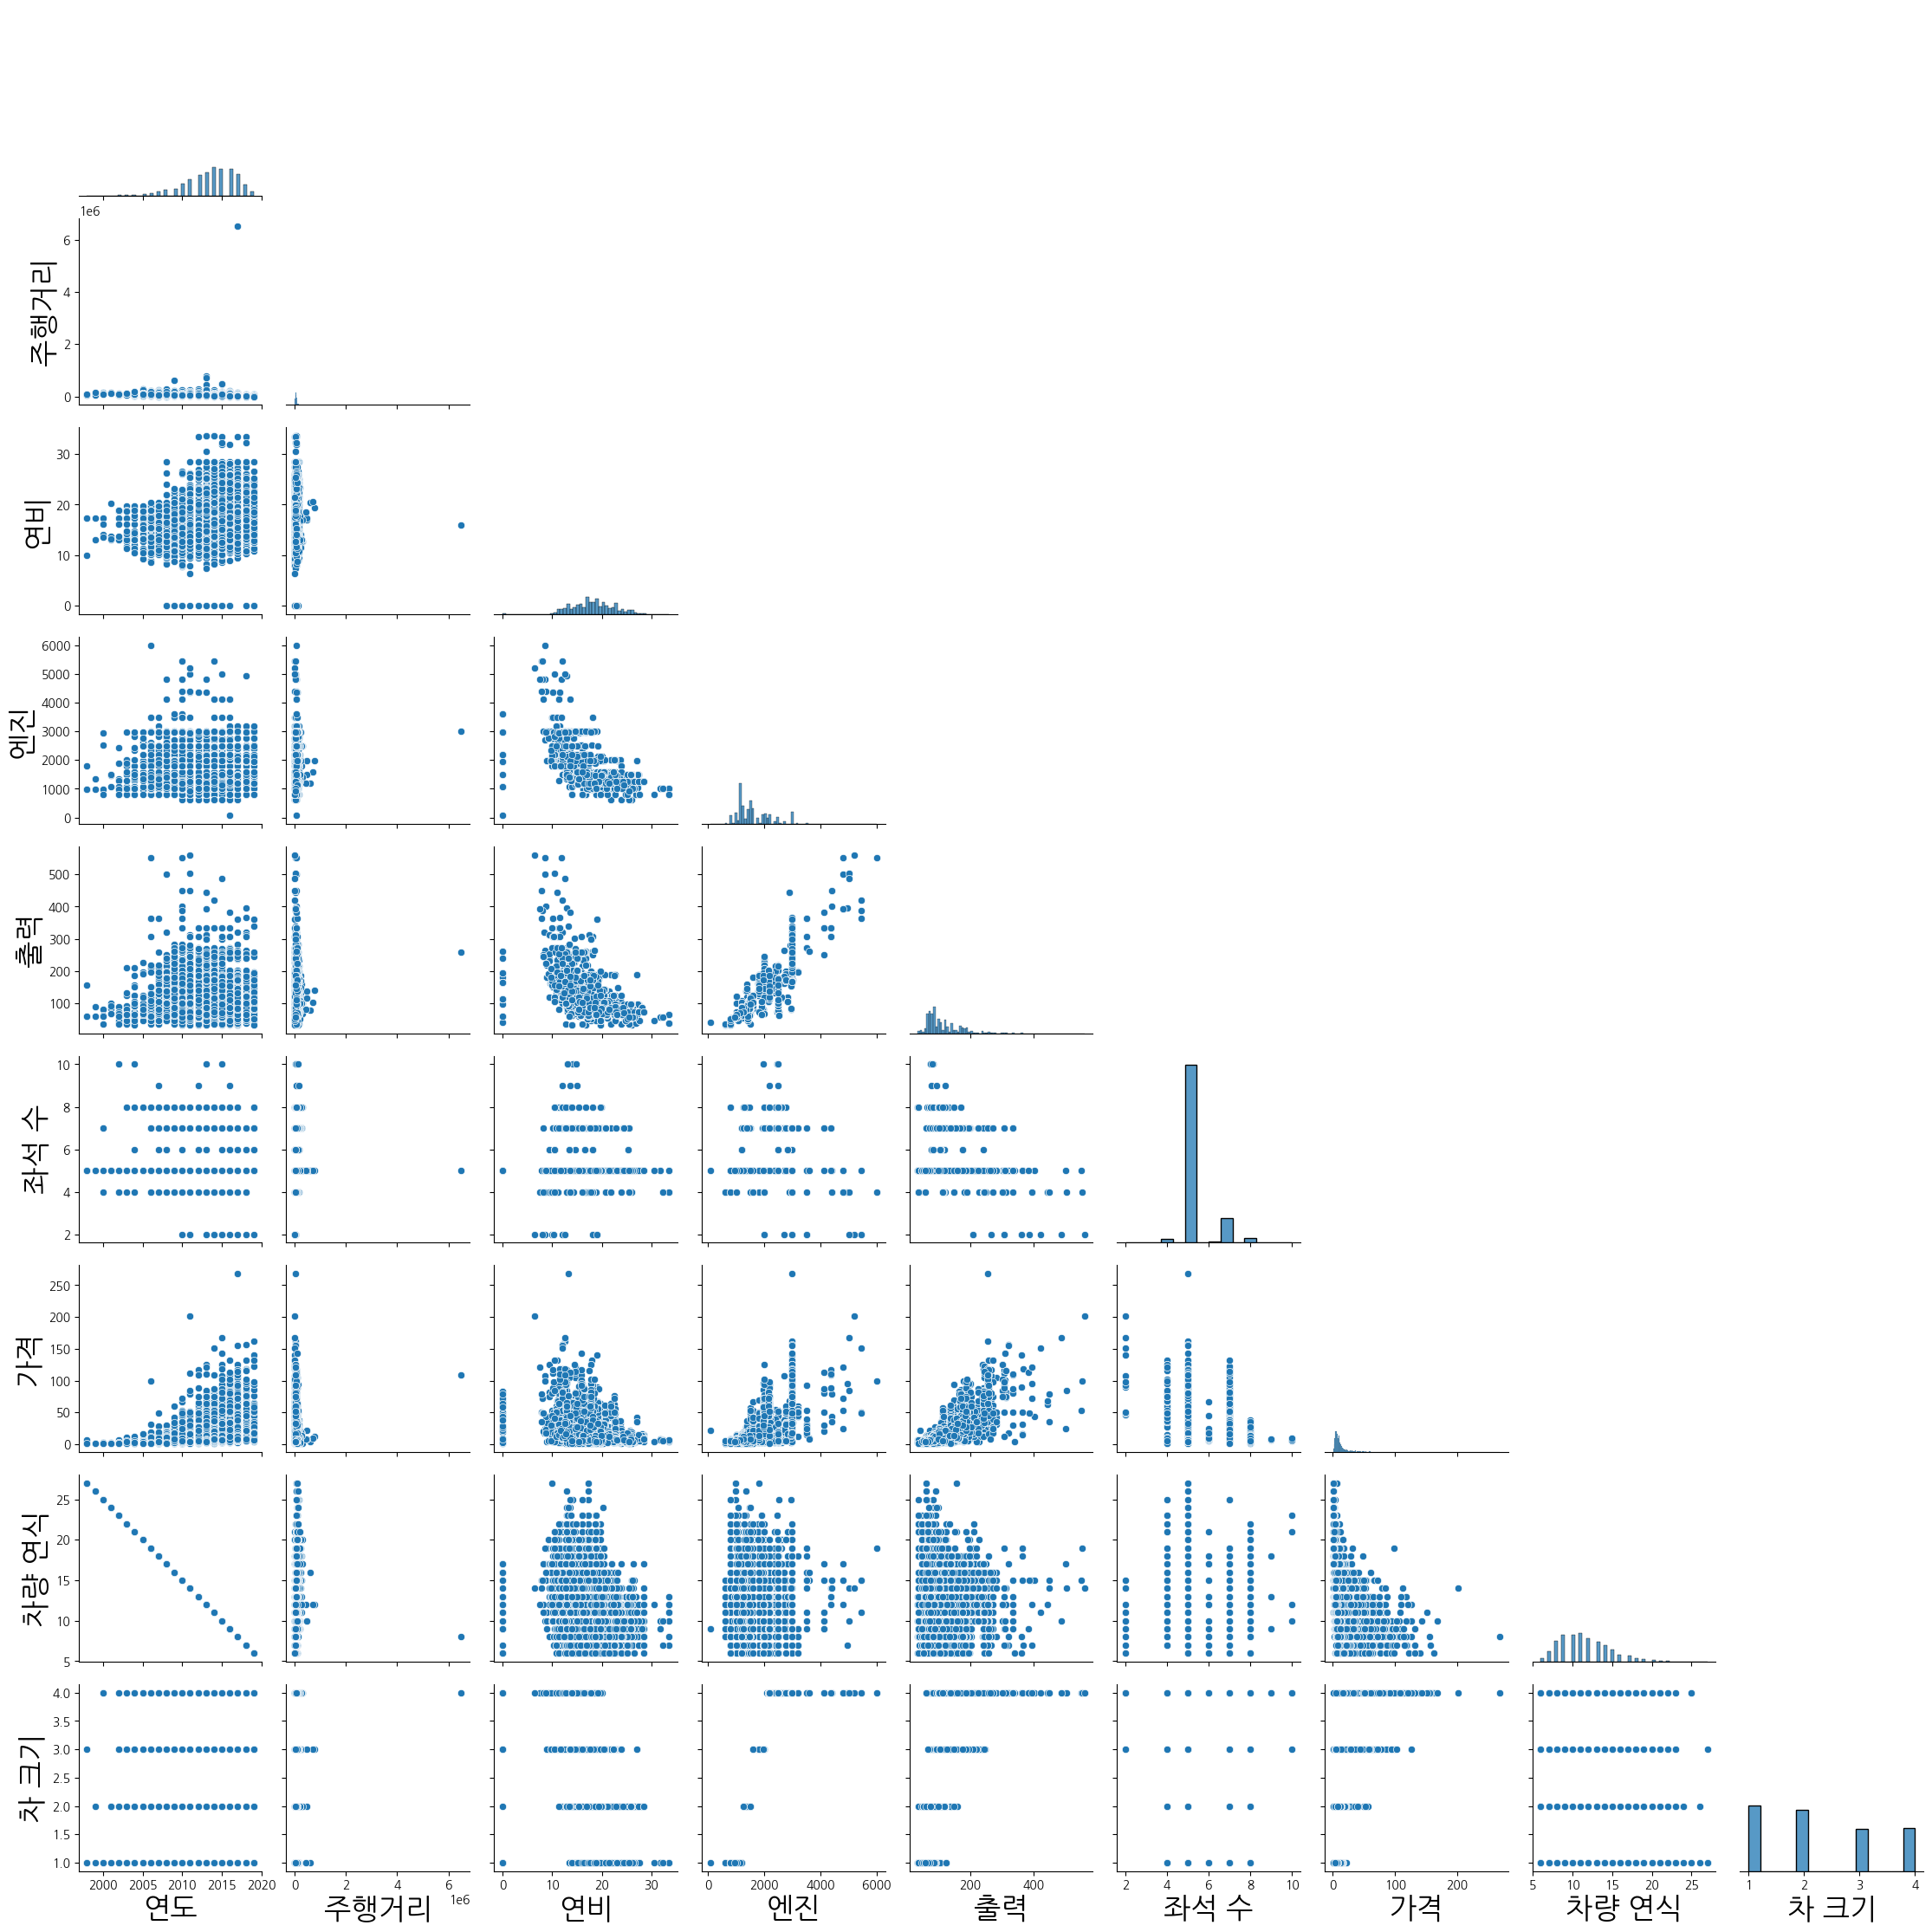

In [462]:
g = sns.pairplot(data=newDF[['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price', 'Ageofcar','Car_size']], corner=True)
labels =                    ["연도", "주행거리", "연비", "엔진", "출력", "좌석 수", "가격", "차량 연식", "차 크기"]

# x축 라벨 변경 (마지막 행)
for ax, label in zip(g.axes[-1, :], labels):
    if ax is not None:
        ax.set_xlabel(label, fontsize=24)

# y축 라벨 변경 (첫 번째 열)
for ax, label in zip(g.axes[:, 0], labels):
    if ax is not None:
        ax.set_ylabel(label, fontsize=24)
plt.show()

In [385]:
## 이상치 처리.
# 데이터프레임 예시
numeric_cols = ['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price', 'Ageofcar', 'Car_size']

# Z-스코어 계산
z_scores = np.abs(stats.zscore(newDF[numeric_cols]))

# 임계값 (보통 3을 사용)
threshold = 3

# 이상치가 아닌 데이터만 남기기
filtered_df = newDF[(z_scores < threshold).all(axis=1)]


In [386]:
newDF = newDF.drop(index=[340, 358, 2328, 1860, 4079, 5781, 5521])
newDF = newDF.drop(index=[2823, 3092, 4491])
newDF = newDF.drop(index=newDF[newDF['Mileage'] == 0].index)
newDF.shape

(5836, 17)

In [417]:
# newDF[(newDF['Price']>80)& (newDF['Year']<2010)]
newDF[newDF['Mileage'] <= 6]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model,Ageofcar,Car_size
S.No.,,,,,,,,,,,,,,,


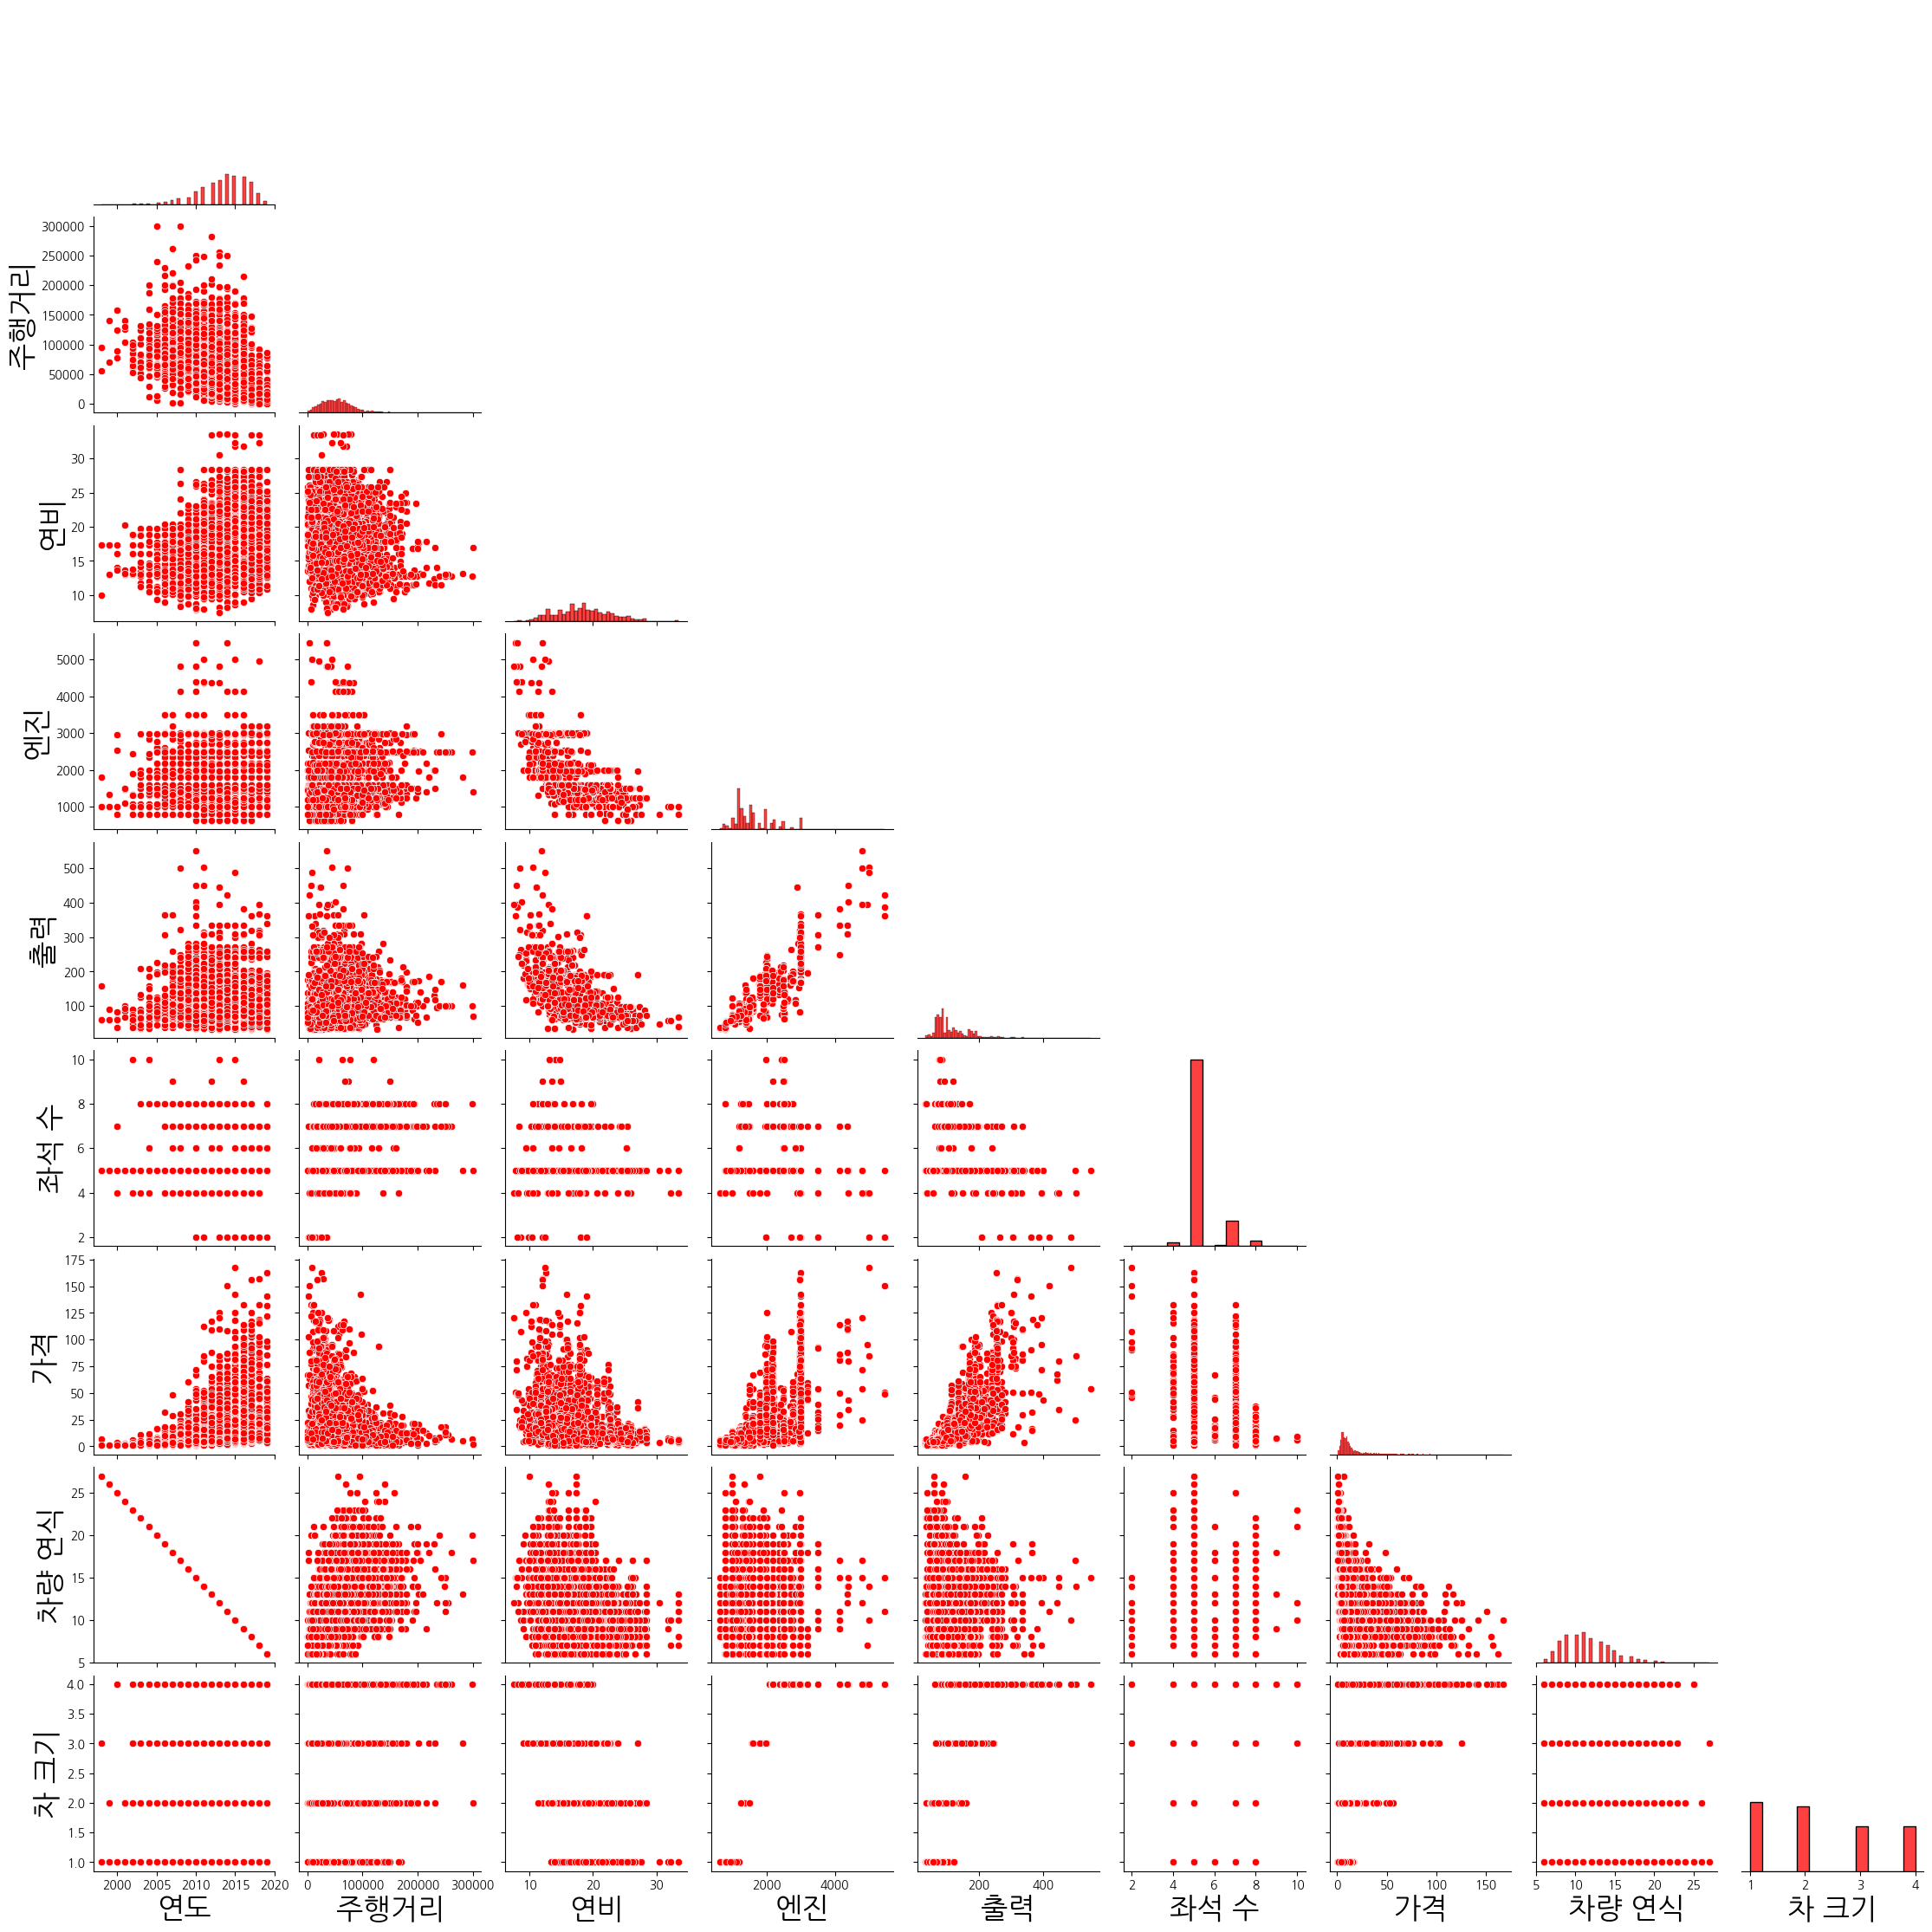

In [420]:
g = sns.pairplot(data=newDF[['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price', 'Ageofcar','Car_size']], corner=True, 
                 plot_kws={'color': 'red'}, diag_kws={'color': 'red'} )
labels = ["연도", "주행거리", "연비", "엔진", "출력", "좌석 수", "가격", "차량 연식", "차 크기"]

# x축 라벨 변경 (마지막 행)
for ax, label in zip(g.axes[-1, :], labels):
    if ax is not None:
        ax.set_xlabel(label, fontsize=24)

# y축 라벨 변경 (첫 번째 열)
for ax, label in zip(g.axes[:, 0], labels):
    if ax is not None:
        ax.set_ylabel(label, fontsize=24)
plt.show()

In [192]:
import pandas as pd
import numpy as np

# 데이터 생성 예시
data = {'Value': [10, 12, 14, 15, 100, 200, 18, 16, 15, 30]}
df = pd.DataFrame(data)

# Z-Score 계산
mean = df['Value'].mean()
std_dev = df['Value'].std()

# Z-Score 계산
df[     'Z_Score'] = (df['Value'] - mean) / std_dev

# 이상치 정의: Z-Score 절댓값이 3보다 큰 값
df_no_outliers = df[df['Z_Score'].abs() <= 3]

print(df_no_outliers)


   Value   Z_Score
0     10 -0.537853
1     12 -0.505256
2     14 -0.472659
3     15 -0.456360
4    100  0.929019
5    200  2.558876
6     18 -0.407464
7     16 -0.440061
8     15 -0.456360
9     30 -0.211881


In [193]:
newDF.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Brand,Model,Ageofcar,Car_size
S.No.,,,,,,,,,,,,,,,,,
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,0.0,26.60,998.0,58.16,5.0,NaN,2.93125,Maruti,WagonR,15,1
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,0.0,19.67,1582.0,126.20,5.0,NaN,20.93750,Hyundai,Creta1.6,10,3
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,0.0,18.20,1199.0,88.70,5.0,8.61 Lakh,7.53750,Honda,JazzV,14,1
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,0.0,20.77,1248.0,88.76,7.0,NaN,10.05000,Maruti,ErtigaVDI,13,2
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,2.0,15.20,1968.0,140.80,5.0,NaN,29.71450,Audi,A4New,12,3


#### newDF 컬럼별 상관관계 분석

In [389]:
newDF['Kilometers_Driven'].sort_values()
# newDF['Kilometers_Driven'].describe()

S.No.
1361       171
5606       600
1198      1000
5339      1000
2054      1000
         ...  
1846    255000
29      262000
1975    282000
1528    299322
3649    300000
Name: Kilometers_Driven, Length: 5836, dtype: int64

In [390]:
# newDF = newDF.drop(index=2328)

In [391]:
# ts.plot_corr(newDF,featureDF.columns,'Price')

In [392]:
newDF['Kilometers_Driven'].describe()

count      5836.000000
mean      56698.982351
std       33509.796557
min         171.000000
25%       33493.250000
50%       52514.500000
75%       72202.500000
max      300000.000000
Name: Kilometers_Driven, dtype: float64

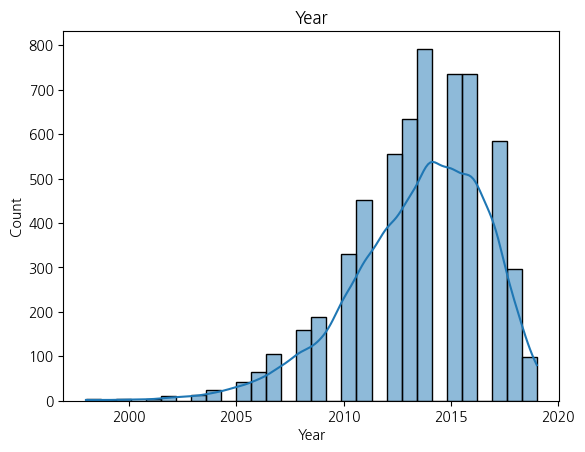

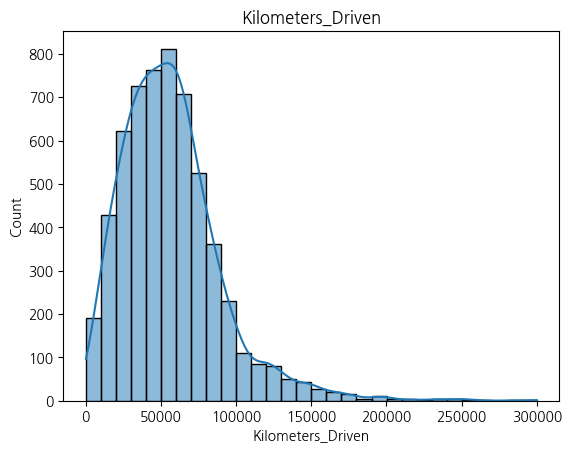

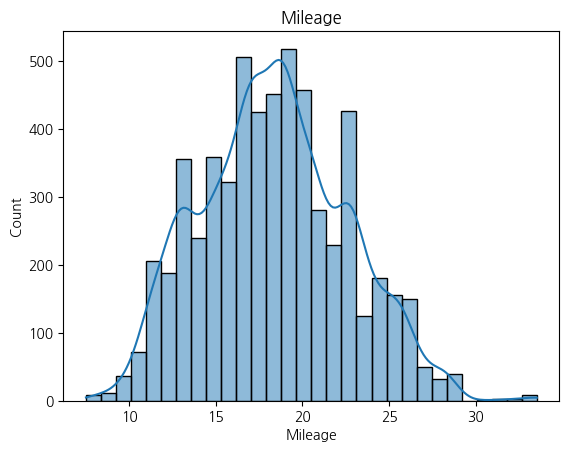

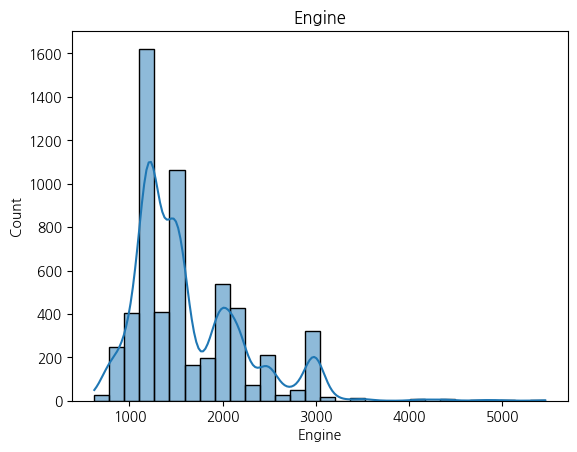

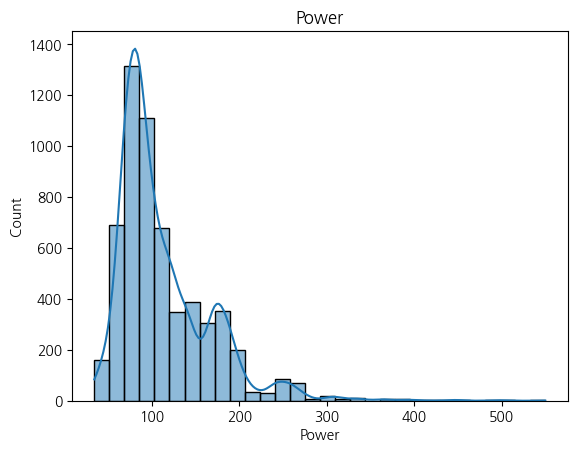

In [393]:
for i in ['Year', 'Kilometers_Driven','Mileage', 'Engine', 'Power']:
    sns.histplot(newDF[i], kde=True, bins=30)
    plt.title(i)
    plt.show()

In [394]:
#['Year', 'Kilometers_Driven','Mileage', 'Engine', 'Power']
# log       robust             standard     scipy.stats.boxcox         log
newDF = newDF.drop(columns=['Name', 'New_Price'])

In [395]:
newDF

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model,Ageofcar,Car_size
S.No.,,,,,,,,,,,,,,,
0,Mumbai,2010,72000,CNG,Manual,0.0,26.60,998.0,58.16,5.0,2.93125,Maruti,WagonR,15,1
1,Pune,2015,41000,Diesel,Manual,0.0,19.67,1582.0,126.20,5.0,20.93750,Hyundai,Creta1.6,10,3
2,Chennai,2011,46000,Petrol,Manual,0.0,18.20,1199.0,88.70,5.0,7.53750,Honda,JazzV,14,1
3,Chennai,2012,87000,Diesel,Manual,0.0,20.77,1248.0,88.76,7.0,10.05000,Maruti,ErtigaVDI,13,2
4,Coimbatore,2013,40670,Diesel,Automatic,2.0,15.20,1968.0,140.80,5.0,29.71450,Audi,A4New,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,Delhi,2014,27365,Diesel,Manual,0.0,28.40,1248.0,74.00,5.0,7.95625,Maruti,SwiftVDI,11,2
6015,Jaipur,2015,100000,Diesel,Manual,0.0,24.40,1120.0,71.00,5.0,6.70000,Hyundai,Xcent1.1,10,1
6016,Jaipur,2012,55000,Diesel,Manual,2.0,14.00,2498.0,112.00,8.0,4.85750,Mahindra,XyloD4,13,4


In [396]:
from sklearn.preprocessing import OneHotEncoder
# OneHotEncoder 설정
typeList = ['Location', 'Fuel_Type', 'Transmission', 'Brand', 'Model']

encoder = OneHotEncoder(drop='first', sparse_output=False,handle_unknown='ignore')  # 첫 번째 카테고리 제거 (다중공선성 방지)

# 범주형 데이터만 인코딩
encoded_array = encoder.fit_transform(newDF[typeList])

# 변환된 컬럼 이름 가져오기
encoded_cols = encoder.get_feature_names_out(typeList)

# 원-핫 인코딩된 데이터프레임 생성
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols)
encoded_df
# 기존 숫자형 컬럼과 합치기
# final_df = pd.concat([newDF.drop(columns=typeList), encoded_df], axis=1)

# final_df.shape
final_df = newDF.drop(columns=typeList).join(encoded_df)

In [397]:
encoded_df

,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,...,Model_i201.4,Model_i202015-2017,Model_i20Active,Model_i20Asta,Model_i20Diesel,Model_i20Era,Model_i20Magna,Model_i20Sportz,Model_redi-GOS,Model_redi-GOT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5831,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5832,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5833,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [398]:
final_df.iloc[:,10:] =encoded_df

In [399]:
final_df

,Year,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,Price,Ageofcar,Car_size,...,Model_i201.4,Model_i202015-2017,Model_i20Active,Model_i20Asta,Model_i20Diesel,Model_i20Era,Model_i20Magna,Model_i20Sportz,Model_redi-GOS,Model_redi-GOT
S.No.,,,,,,,,,,,,,,,,,,,,,
0,2010,72000,0.0,26.60,998.0,58.16,5.0,2.93125,15,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015,41000,0.0,19.67,1582.0,126.20,5.0,20.93750,10,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011,46000,0.0,18.20,1199.0,88.70,5.0,7.53750,14,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012,87000,0.0,20.77,1248.0,88.76,7.0,10.05000,13,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013,40670,2.0,15.20,1968.0,140.80,5.0,29.71450,12,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,2014,27365,0.0,28.40,1248.0,74.00,5.0,7.95625,11,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6015,2015,100000,0.0,24.40,1120.0,71.00,5.0,6.70000,10,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6016,2012,55000,2.0,14.00,2498.0,112.00,8.0,4.85750,13,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [400]:
final_df[final_df.isna()]

,Year,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,Price,Ageofcar,Car_size,...,Model_i201.4,Model_i202015-2017,Model_i20Active,Model_i20Asta,Model_i20Diesel,Model_i20Era,Model_i20Magna,Model_i20Sportz,Model_redi-GOS,Model_redi-GOT
S.No.,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [401]:

f_DF = final_df.drop(columns=['Price'])
targetSR = final_df['Price']
featureDF = f_DF

In [402]:
final_df['Price'].isna()

S.No.
0       False
1       False
2       False
3       False
4       False
        ...  
6014    False
6015    False
6016    False
6017    False
6018    False
Name: Price, Length: 5836, dtype: bool

In [403]:
# targetSR = newDF['Price']
# # featureDF = newDF[['Location_Encoded', 'Year', 'Kilometers_Driven', 'Fuel_Type_Encoded',
# #        'Transmission_Encoded', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
# #        'Brand_Encoded', 'Model_Encoded', 'Ageofcar']]

# featureDF = newDF[[ 'Year','Mileage', 'Engine', 'Power','Ageofcar','Seats']]

In [404]:
nModel = rm()
X_train, X_test, y_train, y_test =nModel.train_test_cut(featureDF,targetSR)

X_train => 2D (4377, 706) / X_test => 2D, (1459, 706)
y_train => 1D (4377,), / y_test => 1D, (1459,)


In [405]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler,FunctionTransformer
lScaler = FunctionTransformer(np.log)
X_train['Year'] = lScaler.fit_transform(X_train[['Year']])
X_train['Power'] = lScaler.fit_transform(X_train[['Power']])
# X_train['Kilometers_Driven'] = lScaler.fit_transform(X_train[['Kilometers_Driven']])
# rScaler = RobustScaler()


sScaler = StandardScaler()
X_train['Engine'] = sScaler.fit_transform(X_train[['Engine']])
X_train['Mileage'] = sScaler.fit_transform(X_train[['Mileage']])

lScaler = FunctionTransformer(np.log)
X_test['Year'] = lScaler.fit_transform(X_test[['Year']])
X_test['Power'] = lScaler.fit_transform(X_test[['Power']])
# X_test['Kilometers_Driven'] = lScaler.fit_transform(X_test[['Kilometers_Driven']])
# rScaler = RobustScaler()
sScaler = StandardScaler()
X_test['Engine'] = sScaler.fit_transform(X_test[['Engine']])
X_test['Mileage'] = sScaler.fit_transform(X_test[['Mileage']])

In [406]:
X_train.isna().sum()

Year                 0
Kilometers_Driven    0
Owner_Type           0
Mileage              0
Engine               0
                    ..
Model_i20Era         0
Model_i20Magna       0
Model_i20Sportz      0
Model_redi-GOS       0
Model_redi-GOT       0
Length: 706, dtype: int64

In [407]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=1000,  # 트리 개수 (기본값: 100)
    max_depth=12,  # 트리의 최대 깊이 (기본값: None, 완전 분기)
    min_samples_split=2,  # 노드를 나누는 최소 샘플 수 (기본값: 2)
    min_samples_leaf=4,  # 리프 노드가 가져야 할 최소 샘플 수 (기본값: 1)
    # max_features='auto',  # 노드 분할 시 고려할 특성 개수 (기본값: "auto")
    bootstrap=True,  # 부트스트랩 샘플링 사용 여부 (기본값: True)
    random_state=42,  # 랜덤 시드 고정 (재현 가능성)
    n_jobs=-1  # 모든 CPU 코어 사용 (병렬 처리)
)

rf_model.fit(X_train, y_train)

# 예측 및 평가
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

print("Random Forest train R² Score:", r2_score(y_train, y_train_pred))        
print("Random Forest test  R² Score:", r2_score(y_test, y_test_pred))        
print(f"Random Forest train_mse : {mean_squared_error(y_train, y_train_pred)}")
print(f"Random Forest test_mse : {mean_squared_error(y_test, y_test_pred)}")
print(f"Random Forest train_loss : {root_mean_squared_error(y_train, y_train_pred)}")
print(f"Random Forest test_loss : {root_mean_squared_error(y_test, y_test_pred)}")


Random Forest train R² Score: 0.9540988227897673
Random Forest test  R² Score: 0.9044407596423676
Random Forest train_mse : 15.383589975448748
Random Forest test_mse : 30.866507163765725
Random Forest train_loss : 3.9221919860517724
Random Forest test_loss : 5.555763418628058


In [408]:
from sklearn.ensemble import RandomForestRegressor

def rf_func(X_train, X_test, y_train, y_test,
            n_estimators=10000,  # 트리 개수 (기본값: 100)
        max_depth=8,  # 트리의 최대 깊이 (기본값: None, 완전 분기)
        min_samples_split=2,  # 노드를 나누는 최소 샘플 수 (기본값: 2)
        min_samples_leaf=2,  # 리프 노드가 가져야 할 최소 샘플 수 (기본값: 1)
        # max_features='auto',  # 노드 분할 시 고려할 특성 개수 (기본값: "auto")
        bootstrap=True,  # 부트스트랩 샘플링 사용 여부 (기본값: True)
        random_state=42,  # 랜덤 시드 고정 (재현 가능성)
        n_jobs=-1):  # 모든 CPU 코어 사용 (병렬 처리)):
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,  # 트리 개수 (기본값: 100)
        max_depth=max_depth,  # 트리의 최대 깊이 (기본값: None, 완전 분기)
        min_samples_split=min_samples_split,  # 노드를 나누는 최소 샘플 수 (기본값: 2)
        min_samples_leaf=min_samples_leaf,  # 리프 노드가 가져야 할 최소 샘플 수 (기본값: 1)
        # max_features='auto',  # 노드 분할 시 고려할 특성 개수 (기본값: "auto")
        bootstrap=bootstrap,  # 부트스트랩 샘플링 사용 여부 (기본값: True)
        random_state=random_state,  # 랜덤 시드 고정 (재현 가능성)
        n_jobs=n_jobs  # 모든 CPU 코어 사용 (병렬 처리)
    )

    rf_model.fit(X_train, y_train)

    # 예측 및 평가
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)

    print("Random Forest train R² Score:", r2_score(y_train, y_train_pred))        
    print("Random Forest test  R² Score:", r2_score(y_test, y_test_pred))        
    print(f"Random Forest train_loss : {root_mean_squared_error(y_train, y_train_pred)}")
    print(f"Random Forest test_loss : {root_mean_squared_error(y_test, y_test_pred)}")


In [409]:
X_train.shape

(4377, 706)

In [410]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# GradientBoostingRegressor 모델 정의
gbm_model = GradientBoostingRegressor(
    n_estimators=100,  # 트리 개수 (기본값: 100)
    learning_rate=0.1,  # 학습률 (기본값: 0.1)
    max_depth=3,  # 각 트리의 최대 깊이 (기본값: 3)
    min_samples_split=2,  # 노드를 나누는 최소 샘플 수 (기본값: 2)
    min_samples_leaf=4,  # 리프 노드가 가져야 할 최소 샘플 수 (기본값: 1)
    subsample=1.0,  # 샘플링 비율 (기본값: 1.0, 전체 샘플을 사용)
    random_state=42,  # 랜덤 시드 고정 (재현 가능성)
)

# 모델 학습
gbm_model.fit(X_train, y_train)

# 예측
y_train_pred = gbm_model.predict(X_train)
y_test_pred = gbm_model.predict(X_test)

# 평가 지표 출력
print("Gradient Boosting train R² Score:", r2_score(y_train, y_train_pred))
print("Gradient Boosting test R² Score:", r2_score(y_test, y_test_pred))
print(f"Gradient Boosting train_mse: {mean_squared_error(y_train, y_train_pred)}")
print(f"Gradient Boosting test_mse: {mean_squared_error(y_test, y_test_pred)}")
print(f"Gradient Boosting train_loss: {mean_squared_error(y_train, y_train_pred) ** 0.5}")
print(f"Gradient Boosting test_loss: {mean_squared_error(y_test, y_test_pred) ** 0.5}")


Gradient Boosting train R² Score: 0.9393839669641537
Gradient Boosting test R² Score: 0.917115396569533
Gradient Boosting train_mse: 20.315213134748017
Gradient Boosting test_mse: 26.772483707255162
Gradient Boosting train_loss: 4.507240079555117
Gradient Boosting test_loss: 5.17421334187673


In [ ]:
X_train

,Year,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,Ageofcar,Car_size,Location_Bangalore,...,Model_i201.4,Model_i202015-2017,Model_i20Active,Model_i20Asta,Model_i20Diesel,Model_i20Era,Model_i20Magna,Model_i20Sportz,Model_redi-GOS,Model_redi-GOT
S.No.,,,,,,,,,,,,,,,,,,,,,
544,7.610358,13190,0.0,-4.181984,0.543726,5.200870,5.0,6,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2618,7.604894,128813,0.0,0.192927,-0.377701,4.234107,5.0,17,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1911,7.608871,77000,0.0,1.914016,-1.039664,4.063198,5.0,9,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3237,7.605890,80000,0.0,-1.844420,1.215669,5.192957,5.0,15,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1382,7.605392,120000,0.0,0.149384,-1.039664,4.206184,5.0,16,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3128,7.606885,23152,0.0,-0.606886,-0.710346,4.248781,5.0,13,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1770,7.609367,8000,0.0,0.080632,-0.708683,4.404644,5.0,8,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4187,7.606885,58000,2.0,1.017950,0.618571,5.247024,5.0,13,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
targetSR = final_df['Price']
featureDF = f_DF


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost 회귀 모델 정의
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,  # 트리 개수
    learning_rate=0.1,  # 학습률
    max_depth=12,  # 트리의 최대 깊이
    min_child_weight=1,  # 자식 노드에 최소 샘플 수
    gamma=0,  # 트리 분할에 대한 최소 손실 감소
    subsample=0.8,  # 각 트리가 학습할 때 사용할 샘플 비율
    colsample_bytree=0.8,  # 각 트리에서 사용할 특성 비율
    random_state=42,  # 랜덤 시드
    n_jobs=-1,  # 사용할 CPU 코어 수 (병렬 처리)
)

# 모델 학습
xgb_model.fit(X_train, y_train)

# 예측
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# 평가 지표 출력
print("XGBoost train R² Score:", r2_score(y_train, y_train_pred))
print("XGBoost test R² Score:", r2_score(y_test, y_test_pred))
print(f"XGBoost train_mse: {mean_squared_error(y_train, y_train_pred)}")
print(f"XGBoost test_mse: {mean_squared_error(y_test, y_test_pred)}")
print(f"XGBoost train_loss: {mean_squared_error(y_train, y_train_pred) ** 0.5}")
print(f"XGBoost test_loss: {mean_squared_error(y_test, y_test_pred) ** 0.5}")


ModuleNotFoundError: No module named 'xgboost'